In [ ]:
import processed_data_generator as pdg
import pandas as pd
from datetime import datetime, timedelta
from train_sarima import get_zone
import random
from forecast_sarima import get_festive_dates

start_time = datetime(2025, 1, 30, 23, 45)
end_time = datetime(2025, 1, 2, 0, 0)
time_interval = timedelta(minutes=15)


data = pdg.generate_fake_parking_data(start_time, end_time, time_interval, [1,2])


df = pd.DataFrame(data)

lat_min, lat_max = 46.04, 46.12
lon_min, lon_max = 11.07, 11.14

# Function to generate random coordinates
def generate_random_coordinates(n):
    latitudes = [random.uniform(lat_min, lat_max) for _ in range(n)]
    longitudes = [random.uniform(lon_min, lon_max) for _ in range(n)]
    return latitudes, longitudes

# Assuming df is your existing DataFrame, get the number of rows in the DataFrame
n = len(df)

# Generate random coordinates
latitudes, longitudes = generate_random_coordinates(n)

# Add the new columns to the existing DataFrame
df['latitude'] = latitudes
df['longitude'] = longitudes

df['parking_type'] = "culo"


df['parking_type'] = df['parking_id'].apply(lambda x: 'street' if x == 1 else 'garage')

# Preprocess data
df['timestamp'] = pd.to_datetime(df['timestamp'])
df['zone'] = df.apply(lambda row: get_zone(row['latitude'], row['longitude']), axis=1)
df.drop(columns=['latitude', 'longitude'], inplace=True)

df['total_capacity'] = df['occupancy'] + df['vacancy']
df['relative_occupancy'] = df['occupancy'] / df['total_capacity']
df['rounded_timestamp'] = df['timestamp'].dt.floor('h')

df_aggregated = df.groupby(['parking_id', 'rounded_timestamp'], as_index=False).agg(
    mean_occupancy=('relative_occupancy', 'mean')
)
df_aggregated['zone'] = df.groupby(['parking_id', 'rounded_timestamp'])['zone'].transform('first')
df_aggregated['parking_type'] = df.groupby(['parking_id', 'rounded_timestamp'])['parking_type'].transform('first')
df_aggregated.rename(columns={'rounded_timestamp': 'timestamp'}, inplace=True)

# Add features
df_aggregated['hour'] = df_aggregated['timestamp'].dt.hour
df_aggregated['day_of_week'] = df_aggregated['timestamp'].dt.dayofweek
df_aggregated['is_festive'] = df_aggregated['timestamp'].dt.date.isin(
    pd.to_datetime(get_festive_dates()).date
) | (df_aggregated['day_of_week'] == 6)

# Encode zones
df_aggregated['zone'] = df_aggregated['zone'].astype(str)
parking_dummies_zone = pd.get_dummies(df_aggregated['zone'], prefix='zone')
df_aggregated = df_aggregated.join(parking_dummies_zone).drop(columns=['zone', 'timestamp'])

# Encode parking type
df_aggregated['parking_type'] = df_aggregated['parking_type'].astype(str)
parking_dummies = pd.get_dummies(df_aggregated['parking_type'], prefix='parking')
df_aggregated = df_aggregated.join(parking_dummies).drop(columns=['parking_type'])

# Rename and prepare training data
df_aggregated.rename(columns={'occupancy': 'mean_occupancy'}, inplace=True)
y_train = df_aggregated['mean_occupancy']

X_train = df_aggregated.drop(columns=['mean_occupancy'])
X_train = X_train.astype(int)
X_train = X_train.apply(pd.to_numeric, errors='coerce').fillna(X_train.mean())

print(df_aggregated.head())
print(df_aggregated.tail())


   mean_occupancy  hour  day_of_week  is_festive  zone_CENTRO  zone_EST  \
0        0.369231     0            3       False         True     False   
1        0.273077     1            3       False         True     False   
2        0.684615     2            3       False         True     False   
3        0.450000     3            3       False         True     False   
4        0.569231     4            3       False        False     False   

   zone_NORD  zone_OVEST  zone_SUD  parking_garage  
0      False       False     False            True  
1      False       False     False            True  
2      False       False     False            True  
3      False       False     False            True  
4       True       False     False            True  
      mean_occupancy  hour  day_of_week  is_festive  zone_CENTRO  zone_EST  \
1387        0.445513    19            3       False        False     False   
1388        0.282051    20            3       False        False      True 

In [57]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error
import numpy as np

# Aggregate occupancy by hour
parking_data = df_aggregated

# Split into training and validation sets
train_data = parking_data[:-168]  # Last 168 hours (7 days) for validation
test_data = parking_data[-168:]

y_train = train_data['mean_occupancy']
y_test = test_data['mean_occupancy']
X_train = train_data.drop(columns=['mean_occupancy'])
X_test = test_data.drop(columns=['mean_occupancy'])

X_train = X_train.astype(int)
X_test = X_test.astype(int)

X_train = X_train.apply(pd.to_numeric, errors='coerce').fillna(X_train.mean())
X_test = X_test.apply(pd.to_numeric, errors='coerce').fillna(X_test.mean())

# Fit SARIMA model (order and seasonal_order are placeholders; these need tuning)
sarima_model = SARIMAX(
    y_train,
    exog=X_train,
    order=(1, 1, 1),                # ARIMA order: (p, d, q)
    seasonal_order=(1, 1, 1, 24), # Seasonal order: (P, D, Q, s) with weekly seasonality
    enforce_stationarity=False,
    enforce_invertibility=False
)
sarima_result = sarima_model.fit()

print("Now doing the forecast")
# Forecast the next 7 days (168 hours)
forecast = sarima_result.forecast(steps=168, exog=X_test)


print("evaluation time")
# Evaluate the model
mae = mean_absolute_error(y_test, forecast)
print(f"Mean Absolute Error: {mae}")


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.14661D-01    |proj g|=  1.67604D+00


 This problem is unconstrained.



At iterate    5    f= -3.40684D-01    |proj g|=  4.21714D-01

At iterate   10    f= -4.02511D-01    |proj g|=  1.52402D-01

At iterate   15    f= -4.34921D-01    |proj g|=  2.17503D-01

At iterate   20    f= -4.38648D-01    |proj g|=  9.20730D-02

At iterate   25    f= -4.40652D-01    |proj g|=  3.00062D-02

At iterate   30    f= -4.40850D-01    |proj g|=  6.81192D-03

At iterate   35    f= -4.40857D-01    |proj g|=  5.51048D-03

At iterate   40    f= -4.40859D-01    |proj g|=  1.55847D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   11     40     60      1     0     0   1.558D-04  -4.409D-01
  F = -0.440858978650

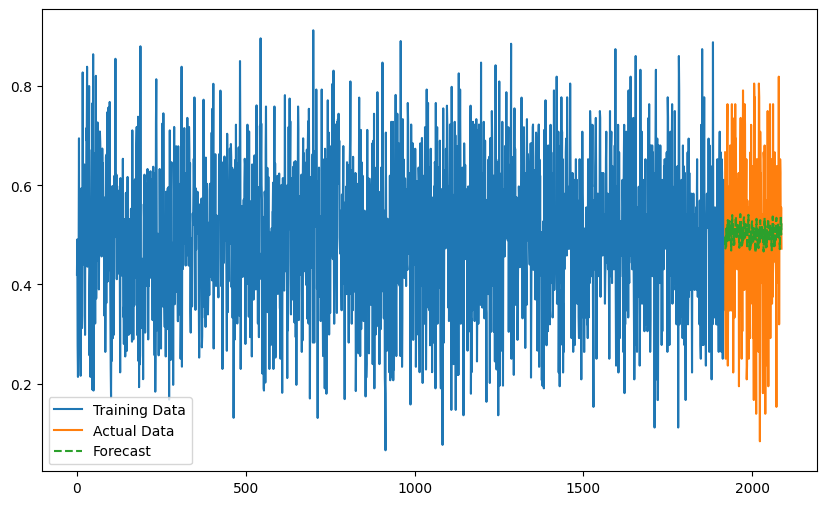

In [59]:
# Plot the results
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.plot(train_data['mean_occupancy'], label='Training Data')
plt.plot(test_data['mean_occupancy'], label='Actual Data')
plt.plot(forecast, label='Forecast', linestyle='--')
plt.legend()
plt.show()

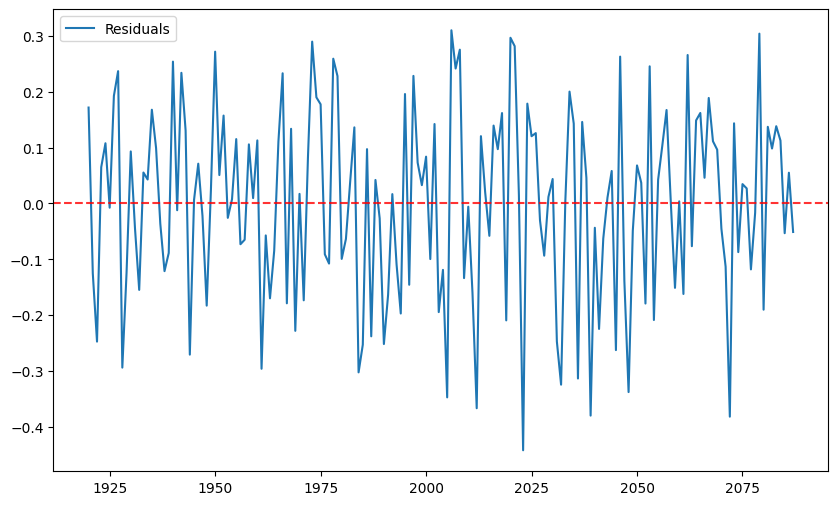

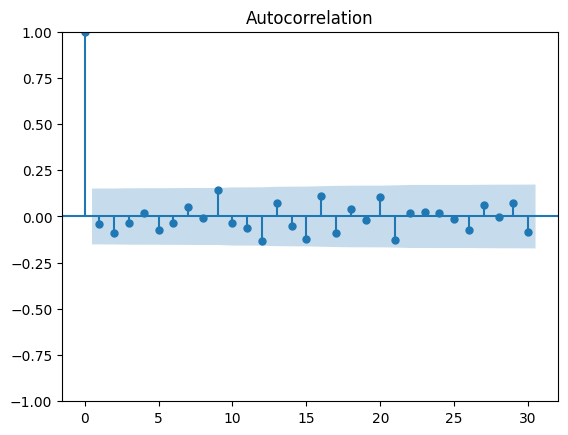

In [61]:
# Residuals
residuals = test_data["mean_occupancy"] - forecast

# Plot residuals
plt.figure(figsize=(10, 6))
plt.plot(residuals, label="Residuals")
plt.axhline(0, color='red', linestyle='--', alpha=0.8)
plt.legend()
plt.show()

# ACF Plot
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(residuals.dropna(), lags=30)
plt.show()


In [63]:
datetime.now().strftime("%Y-%m-%d %H:%M:%S")

'2025-01-27 13:19:44'

In [ ]:
VALID_ZONES = ["NORD", "SUD", "CENTRO", "EST", "OVEST"]
    

    
new_records = []
for i in range(168):
    new_records.append({
        "parking_id": 1,
        "timestamp": start_time + timedelta(hours=i)
    })

festive_dates = get_festive_dates()

df_aggregated = pd.DataFrame(new_records)
df_aggregated['timestamp'] = pd.to_datetime(df_aggregated['timestamp'])
df_aggregated['zone'] = "NORD"

df_aggregated['hour'] = df_aggregated['timestamp'].dt.hour
df_aggregated['day_of_week'] = df_aggregated['timestamp'].dt.dayofweek  # 0=Monday, 6=Sunday
df_aggregated['is_festive'] = df_aggregated['day_of_week'].apply(lambda x: 1 if x == 6 else 0)  # Sunday is festive
df_aggregated['is_festive'] = df_aggregated['timestamp'].dt.date.isin(pd.to_datetime(festive_dates).date) | df_aggregated['is_festive']

# Create dummy columns for each zone
for valid_zone in VALID_ZONES:
    df_aggregated[f'zone_{valid_zone}'] = (df_aggregated['zone'] == valid_zone).astype(int)

df_aggregated.drop(columns=['zone', 'timestamp', 'parking_id'], inplace=True)

df_aggregated = df_aggregated.astype(int)
df_aggregated = df_aggregated.apply(pd.to_numeric, errors='coerce').fillna(df_aggregated.mean())

print(df_aggregated.head())
print(df_aggregated.tail())

   hour  day_of_week  is_festive  zone_NORD  zone_SUD  zone_CENTRO  zone_EST  \
0    23            3           0          1         0            0         0   
1     0            4           0          1         0            0         0   
2     1            4           0          1         0            0         0   
3     2            4           0          1         0            0         0   
4     3            4           0          1         0            0         0   

   zone_OVEST  
0           0  
1           0  
2           0  
3           0  
4           0  
     hour  day_of_week  is_festive  zone_NORD  zone_SUD  zone_CENTRO  \
163    18            3           0          1         0            0   
164    19            3           0          1         0            0   
165    20            3           0          1         0            0   
166    21            3           0          1         0            0   
167    22            3           0          1         0        

In [5]:
datetime.now()

end_time = datetime.now() - timedelta(days=28)
print(end_time)

2024-12-30 15:11:00.940360
